# Laboratorio 1
## Integrantes:
- José Antonio Mérida -- 201105
- Joaquín Puente -- 22296 

### Imports y Funciones de Utilidad

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

def plot_walk_forward(
    train, test, preds, 
    col=None, 
    title="Walk Forward Validation", 
    ylabel="Value"
):
    import matplotlib.pyplot as plt
    import pandas as pd
    from sklearn.metrics import mean_squared_error
    import numpy as np

    # Auto-detect column if not provided
    if col is None:
        col = train.columns[0] if hasattr(train, "columns") else None
        if col is None:
            raise ValueError("Column name must be provided if train/test are Series.")

    preds_series = pd.Series(preds, index=test.index)

    plt.figure(figsize=(10, 5))

    # Combine train and the first test point for a continuous blue line
    train_plus_first_test = pd.concat([train, test.iloc[:1]])

    # Plot training region in blue (including first test point)
    plt.plot(
        train_plus_first_test.index, train_plus_first_test[col],
        color='blue', linewidth=2, label='Observed (Train)', zorder=2
    )

    # Plot test region in green (starts at first test point)
    plt.plot(
        test.index, test[col],
        color='green', linewidth=2, label='Observed (Test)', zorder=3
    )

    # Plot predictions in red dashed
    plt.plot(
        preds_series.index, preds_series,
        color='red', linestyle='--', linewidth=2, label='Prediction', zorder=4
    )

    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
    plt.legend()
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    plt.show()

    rmse = np.sqrt(mean_squared_error(test[col], preds))
    print(f"RMSE: {rmse:.2f}")
    return rmse

## shampoo.csv

### 1. Análisis Exploratorio

/tmp/ipykernel_3184/1022166198.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  datos = pd.read_csv(f'datasets/{filename}',


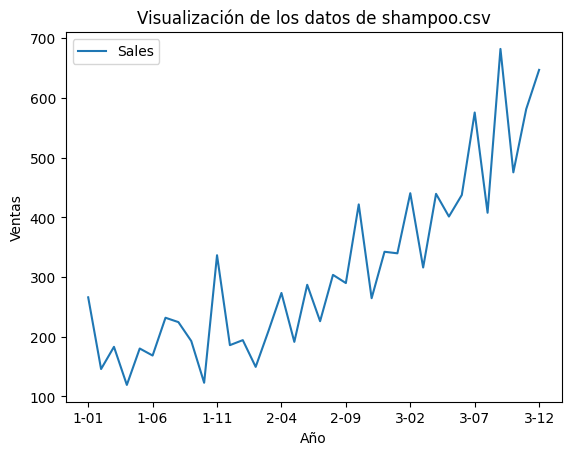

In [48]:
# Leer los datos
filename = 'shampoo.csv'
datos = pd.read_csv(f'datasets/{filename}',
                    index_col = 'Month',
                    parse_dates = True)

datos.index.freq = 'MS'

# Graficar los datos y predicciones

datos.plot(label = 'Observadod')

plt.legend()
plt.title(f"Visualización de los datos de {filename}")
plt.xlabel("Año")
plt.ylabel("Ventas")
plt.show()

Descripcion

Decidimos dividirlo X

In [49]:
# Split: 29 for train, 7 for test
train_size = 29
train = datos.iloc[:train_size]
test = datos.iloc[train_size:]

### 2. Promedios Móviles

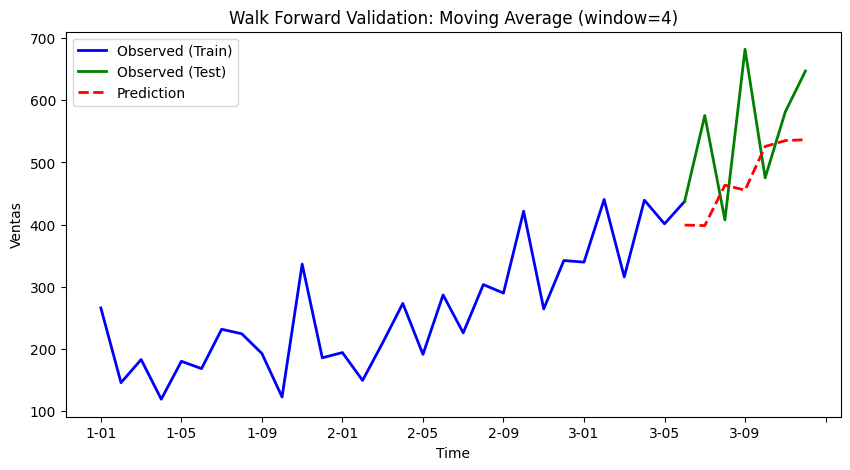

RMSE: 121.93


np.float64(121.93388284523003)

In [50]:
window = 4
history = list(train['Sales'])
preds = []

for t in range(len(test)):
    if len(history) >= window:
        pred = np.mean(history[-window:])
    else:
        pred = np.mean(history)
    preds.append(pred)
    history.append(test['Sales'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Sales',
    title="Walk Forward Validation: Moving Average (window=4)",
    ylabel="Ventas"
)

Window: 2, RMSE: 113.15
Window: 3, RMSE: 111.51
Window: 4, RMSE: 121.93
Window: 5, RMSE: 119.48
Window: 6, RMSE: 132.06
Window: 7, RMSE: 137.13
Window: 8, RMSE: 146.07
Window: 9, RMSE: 151.57
Window: 10, RMSE: 159.67
Window: 11, RMSE: 164.96
Window: 12, RMSE: 173.24

Best window: 3 with RMSE: 111.51


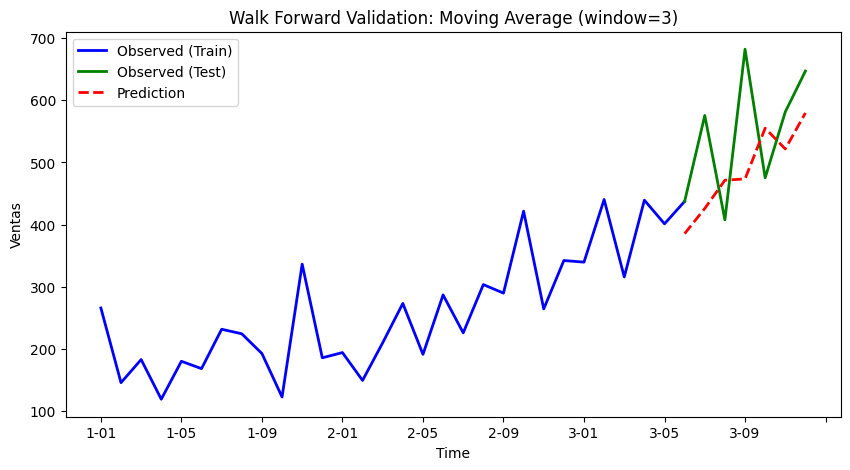

RMSE: 111.51


np.float64(111.5106230258761)

In [ ]:
best_rmse = float('inf')
best_window = None
best_preds = None

for window in range(2, 13):
    history = list(train['Sales'])
    preds = []
    for t in range(len(test)):
        if len(history) >= window:
            pred = np.mean(history[-window:])
        else:
            pred = np.mean(history)
        preds.append(pred)
        history.append(test['Sales'].iloc[t])
    rmse = np.sqrt(mean_squared_error(test['Sales'], preds))
    print(f"Window: {window}, RMSE: {rmse:.2f}")
    if rmse < best_rmse:
        best_rmse = rmse
        best_window = window
        best_preds = preds

print(f"\nBest window: {best_window} with RMSE: {best_rmse:.2f}")

# Plot the best result
plot_walk_forward(
    train, test, best_preds, col='Sales',
    title=f"Walk Forward Validation: Moving Average (window={best_window})",
    ylabel="Ventas"
)

### Alisamiento exponencial

### Holt winters

### SARIMA

### Prophet

## monthly-mean-temp.csv

### Análisis exploratorio

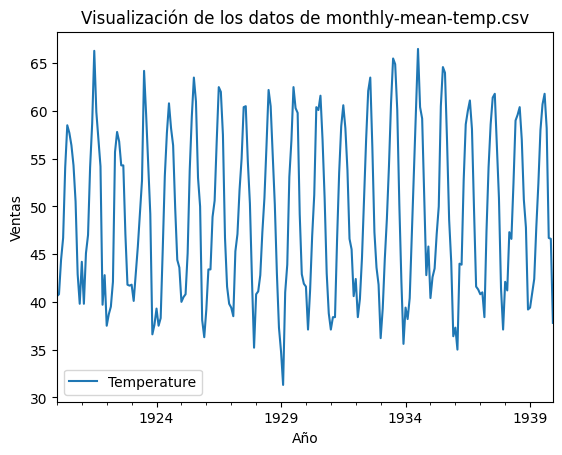

In [52]:
# Leer los datos
filename = 'monthly-mean-temp.csv'
datos = pd.read_csv(f'datasets/{filename}',
                    index_col = 'Month',
                    parse_dates = True)

datos.index.freq = 'MS'

# Graficar los datos y predicciones

datos.plot(label = 'Observadod')

plt.legend()
plt.title(f"Visualización de los datos de {filename}")
plt.xlabel("Año")
plt.ylabel("Ventas")
plt.show()

### Promedios móviles

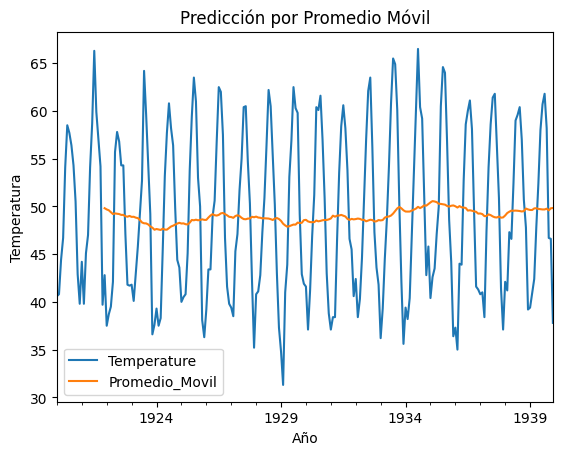

In [53]:
# Promedio Móvil

datos['Promedio_Movil'] = datos['Temperature'].rolling(window = 24).mean()

# Graficar los datos y el Promedio Móvil

datos[['Temperature', 'Promedio_Movil']].plot()
plt.title("Predicción por Promedio Móvil")
plt.xlabel("Año")
plt.ylabel("Temperatura")
plt.show()

### Alisamiento exponencial

### Holt winters

### SARIMA

### Prophet

### Comparacion y Evaluacion

## monthly-car-sales.csv

### Análisis exploratorio

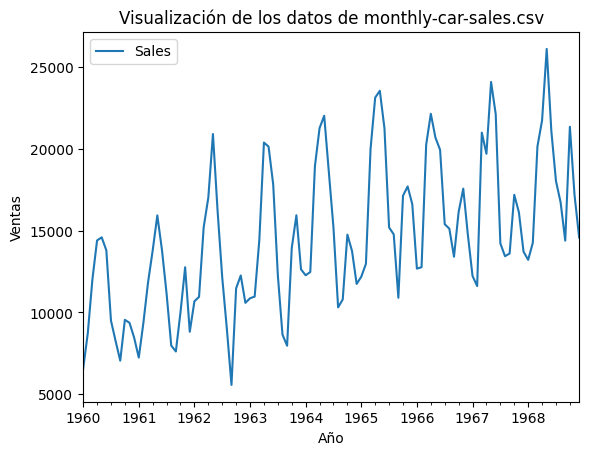

In [54]:
# Leer los datos
filename = 'monthly-car-sales.csv'
datos = pd.read_csv(f'datasets/{filename}',
                    index_col = 'Month',
                    parse_dates = True)

datos.index.freq = 'MS'

# Graficar los datos y predicciones

datos.plot(label = 'Observadod')

plt.legend()
plt.title(f"Visualización de los datos de {filename}")
plt.xlabel("Año")
plt.ylabel("Ventas")
plt.show()

### Promedios móviles

### Alisamiento exponencial

### Holt winters

### ARIMA

### Prophet

### Comparacion y Evaluacion

## daily-total-female-births.csv

### Análisis exploratorio

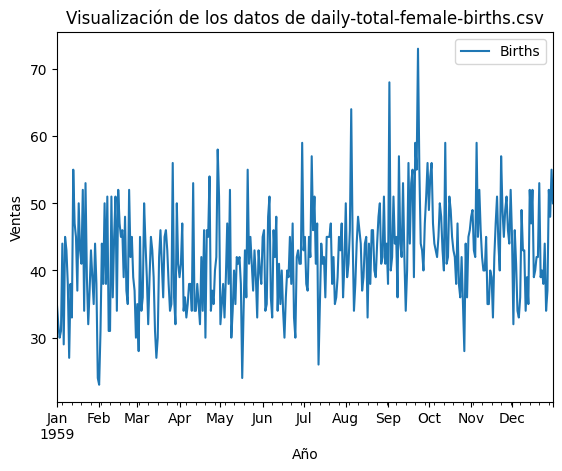

In [55]:
# Leer los datos
filename = 'daily-total-female-births.csv'
datos = pd.read_csv(f'datasets/{filename}',
                    index_col = 'Date',
                    parse_dates = True)

datos.index.freq = 'D'

# Graficar los datos y predicciones

datos.plot(label = 'Observadod')

plt.legend()
plt.title(f"Visualización de los datos de {filename}")
plt.xlabel("Año")
plt.ylabel("Ventas")
plt.show()

### Promedios móviles

### Alisamiento exponencial

### Holt winter

### ARIMA

### Prophet

### Comparacion y Evaluacion